A lot of content based on [Time Series Forecasting in Python](https://learning.oreilly.com/library/view/time-series-forecasting) by Marco Peixeiro. I'll try to do my own code examples, but following the general structure of his book. Also, what seems an encouraging book as well is [Modern Time Series Forecasting with Python](https://learning.oreilly.com/library/view/modern-time-series) by Manu Joseph which explains some different concepts really well I'll look at later. 

Simply put, a time series is a set of values in order in time. A time series is _stationary_ if the statistical properties do not change over time. This is not usually the case, and retaining these properties can be advantageous in some cases, but it is useful to break down a time series into different components and we can start with stationarity. The simplest technique for this is to take the difference between two timesteps:

$y_t' = y_{t} - y_{t-1}$

Simples! This makes the mean more stable and reduces trend effects. If we want to stabilise the variance, we can apply a log transformation to the result of $y_t'$.

Doing it once is "first order" differencing, we may need to do it many times to obtain stationary data. What's the difference? Let's take a look

Assumes I've already run `pip install sktime statsmodels` we'll get the boring airline dataset which is ubiquitous in most time series blogs I've read.  


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sktime.datasets import load_airline

<Axes: xlabel='Period'>

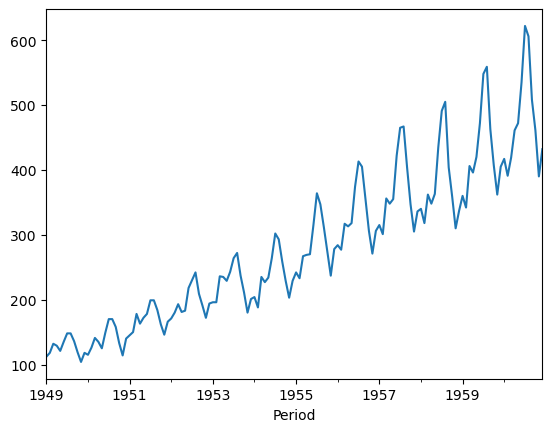

In [2]:
df = load_airline()
df.plot()

## How do we know if the time series is stationary?

We can tell just by looking that this is not constant over time. The value increases year on year, although there are also clear seasonal peaks. So what does it look like if we apply a differencing or a log to it?

Incidentally, the first time I've used `np.diff(data, n=1)` instead of df.shift(1). This is much nicer, as `n` is the order of diffs, how many times it's done. I still need to wrap it in a `pd.DataFrame` to plot because I don't like using matplotlib directly if I can avoid it.

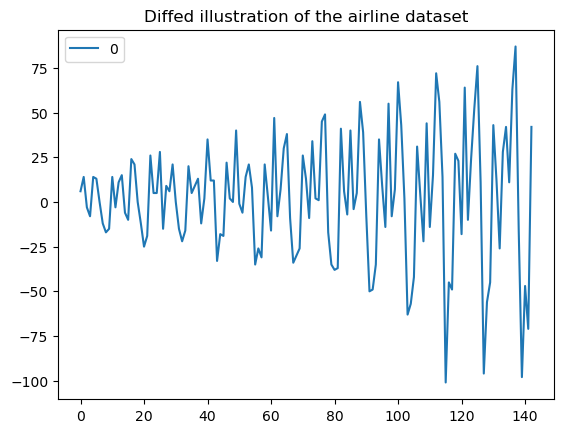

In [3]:
diffed1 = (df - df.shift(1))
diffed1 = pd.DataFrame(np.diff(df, n=1))
diffed1.plot(title="Diffed illustration of the airline dataset");

Is this stationary? The mean appears to be much more consistent as the higher and lower values fluctuate around the same amount +/- from 0, yet the variance does appear to be changing as the fluctuations are getting bigger and bigger. Let's try applying the log to it:

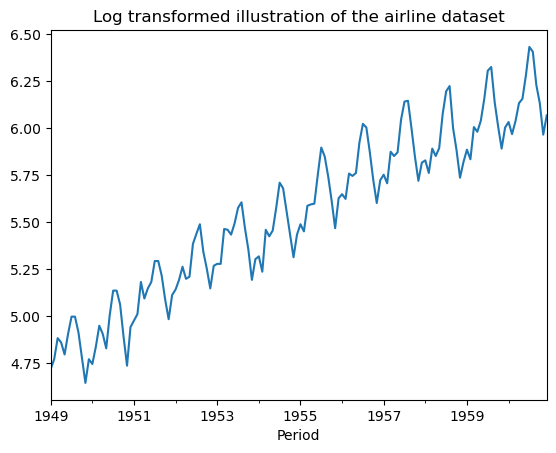

In [4]:
logged = np.log(df)
logged.plot(title="Log transformed illustration of the airline dataset");

This does indeed appear to have stabilised the variance, but the mean is clearly still increasing. What about if we did both get the log and the diff?

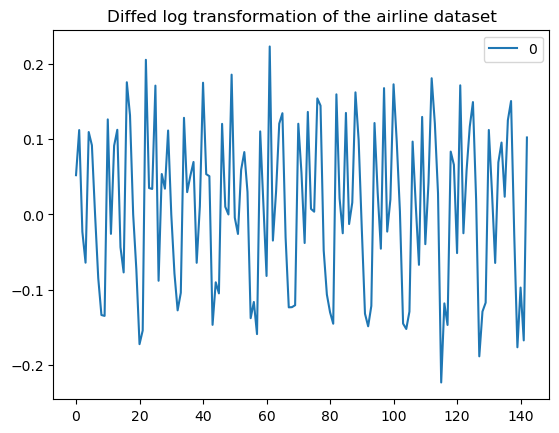

In [5]:
log_and_diff = pd.DataFrame(np.diff(logged, n=1))
log_and_diff.plot(title="Diffed log transformation of the airline dataset");

That one does look to be mostly consistent _and_ have far more consistent variance, which is what we want. But how do we tell if they are stationary? This is done by applying the [Augmented Dickey-Fuller (ADF) test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test). This is a hypothesis test which has as its null hypothesis that there exists a unit root in the time series which is usually a sign of a non-stationary dataset. I confess I'm not fully on top of the details of what or why this is, but luckily there is a Python function which does the hard work in the `statsmodels` package, so all I need to do is be able to interpret it for now (can figure out the details later). 

If it is possible to reject the hypothesis, the ADF statistic will be negative. The [Python implementation](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html) also provides a p-value which you use in the normal way.

In [6]:
# Test the initial series (clearly not stationary)
from statsmodels.tsa.stattools import adfuller
res = adfuller(df.values)
res

(0.8153688792060511,
 0.991880243437641,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.692930839019)

In [7]:
# Test the diffed series (Not stationary, but pretty close to 0.05)
adfuller(diffed1.dropna())

(-2.8292668241699874,
 0.05421329028382711,
 12,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 988.5069317854084)

In [8]:
# Test the logged series (Not stationary, but pretty close to 0.05)
adfuller(logged.dropna())

(-1.7170170891069667,
 0.42236677477038814,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 -445.3990312497209)

In [9]:
# Still not stationary
adfuller(log_and_diff.dropna())

(-2.7171305983880893,
 0.071120548150866,
 14,
 128,
 {'1%': -3.4825006939887997,
  '5%': -2.884397984161377,
  '10%': -2.578960197753906},
 -440.35846985568105)

In [10]:
# We can be pretty confident that this is stationary given the low DF statistic
adfuller((log_and_diff - log_and_diff.shift(1)).dropna())

(-8.196629132182252,
 7.419304549375567e-13,
 13,
 128,
 {'1%': -3.4825006939887997,
  '5%': -2.884397984161377,
  '10%': -2.578960197753906},
 -430.89362828642675)

Note that although we care about the variance too, it does not seem to be necessary to include that for stationarity. If we do a second-order diff we still get a high level of significance

In [11]:
adfuller((diffed1 - diffed1.shift(1)).dropna())

(-16.384231542468523,
 2.7328918500141235e-29,
 11,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 988.6020417275602)

## Autocorrelation

It's also important to test for autocorrelation, to ascertain whether the time series can be reasonably modelled. If it is stationary and auto-correlates somehow then it can be modelled with one of the AR or MA family of models. If not, then it is likely a random walk and obtaining an accurate model becomes difficult/impossible.

As the name suggests, autocorrelation measures whether the time series is correlated with previous values in the time series. It's not difficult to understand, and statsmodels has a convenient plot method to show the correlation between $t$ and $t-n$. For the airline dataset:


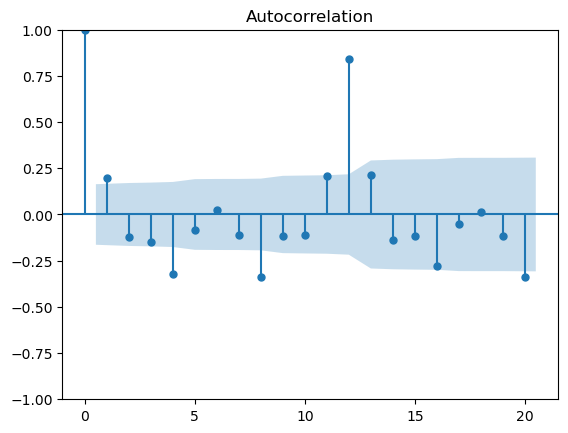

In [12]:
from statsmodels.graphics.tsaplots import plot_acf 
plot_acf(log_and_diff, lags=20); 

Here we can see that there is indeed a strong correlation between $t$ and $t-12$. Given that this is a time series with a yearly pattern, this is not surprising and indicates that the series is not white noise. 